In [2]:
from deep_traffic_generation.VAE_Generation import SingleStageVAE
from deep_traffic_generation.AE_Generation import AutoEncoder
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import numpy as np
from os import walk

# Problem and data

In [3]:
from traffic.core import Traffic
traffic = Traffic.from_file("../../deep_traffic_generation/data/t_lszh_2019_04.pkl") 

In [3]:
# North concept
tl14 = (
    traffic
    .next('aligned_on_ils("LSZH")')
    .query("ILS == '14'")
    .last("1 min")
    .eval(max_workers=4)
)

tl16 = (
    traffic
    .next('aligned_on_ils("LSZH")')
    .query("ILS == '16'")
    .last("1 min")
    .eval(max_workers=4)
)

tt28 = (
    traffic
    .next('takeoff_from_runway("LSZH")')
    .query("runway == '28'")
    .query("onground == False")
    .first("1 min")
    .eval(max_workers=4)
)

tt16 = (
    traffic
    .next('takeoff_from_runway("LSZH")')
    .query("runway == '16'")
    .query("onground == False")
    .first("1 min")
    .eval(max_workers=4)
)

In [4]:
# East concept
tl28 = (
    traffic
    .next('aligned_on_ils("LSZH")')
    .query("ILS == '28'")
    .last("1 min")
    .eval(max_workers=50)
)

tt28 = (
    traffic
    .next('takeoff_from_runway("LSZH")')
    .query("runway == '28'")
    .query("onground == False")
    .first("1 min")
    .eval(max_workers=50)
)

tt32 = (
    traffic
    .next('takeoff_from_runway("LSZH")')
    .query("runway == '32'")
    .query("onground == False")
    .first("2 min")
    .eval(max_workers=50)
)

In [8]:
# South concept
tl34 = (
    traffic
    .next('aligned_on_ils("LSZH")')
    .query("ILS == '34'")
    .last("1 min")
    .eval(max_workers=50)
)

# tt28 = (
#     traffic
#     .next('takeoff_from_runway("LSZH")')
#     .query("runway == '28'")
#     .query("onground == False")
#     .first("1 min")
#     .eval(max_workers=4)
# )

# tt32 = (
#     traffic
#     .next('takeoff_from_runway("LSZH")')
#     .query("runway == '32'")
#     .query("onground == False")
#     .first("2 min")
#     .eval(max_workers=4)
# )

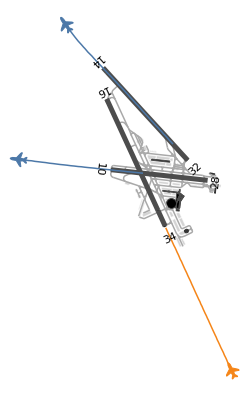

In [9]:
from traffic.data import airports
from traffic.core.projection import EuroPP

with plt.style.context('traffic'):
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=EuroPP()))
    airports['LSZH'].plot(ax, labels=dict(fontsize=11))
    ax.spines['geo'].set_visible(False)
    tl34[1].plot(ax, color="#f58518")
    tl34[1].at_ratio(0).plot(
        ax,
        color="#f58518",
        text_kw = {"s": None}
    )
    # tl16[0].plot(ax, color="#f58518")
    # tl16[0].at_ratio(0).plot(
    #     ax,
    #     color="#f58518",
    #     text_kw = {"s": None}
    # )
    tt28[0].plot(ax, color="#4c78a8")
    tt28[0].at_ratio(1).plot(
        ax,
        color="#4c78a8",
        text_kw = {"s": None}
    )

    tt32[10].plot(ax, color="#4c78a8")
    tt32[10].at_ratio(1).plot(
        ax,
        color="#4c78a8",
        text_kw = {"s": None}
    )

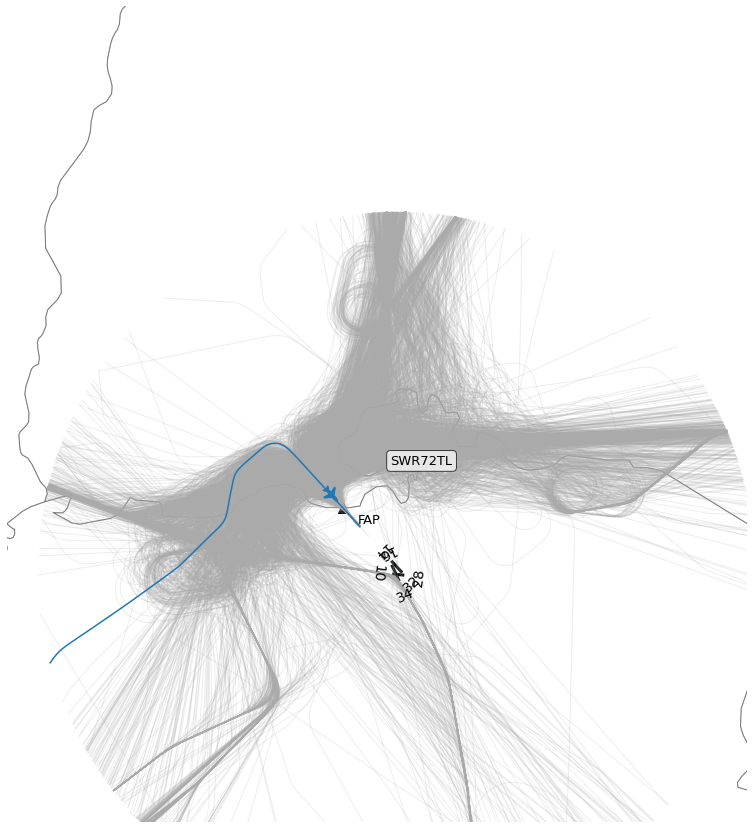

In [6]:
from traffic.core import Traffic
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports
traffic = Traffic.from_file("../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl") 


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((7.5, 9.5, 47, 48.5))

    traffic[:4000].plot(ax, alpha=0.2)

    k =  np.random.randint(len(traffic))
    traffic[k].plot(ax, color="#1f77b4", lw=1.5)
    traffic[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# Autoencoder

## FCAE

In [8]:
dataset_FCAE = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="linear",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [9]:
path = "../../deep_traffic_generation/lightning_logs/fcae/version_3/"

t_FCAE = AutoEncoder(X = dataset_FCAE, AE_type="FCAE")
t_FCAE.load(path, dataset_FCAE.parameters)
g_FCAE = Generation(generation=t_FCAE, features = t_FCAE.AE.hparams.features, scaler=dataset_FCAE.scaler) 

Explained variance ratio :  [0.43426374 0.12905996]
Clustering done
traffic :  0
traffic :  1
traffic :  2
traffic :  3


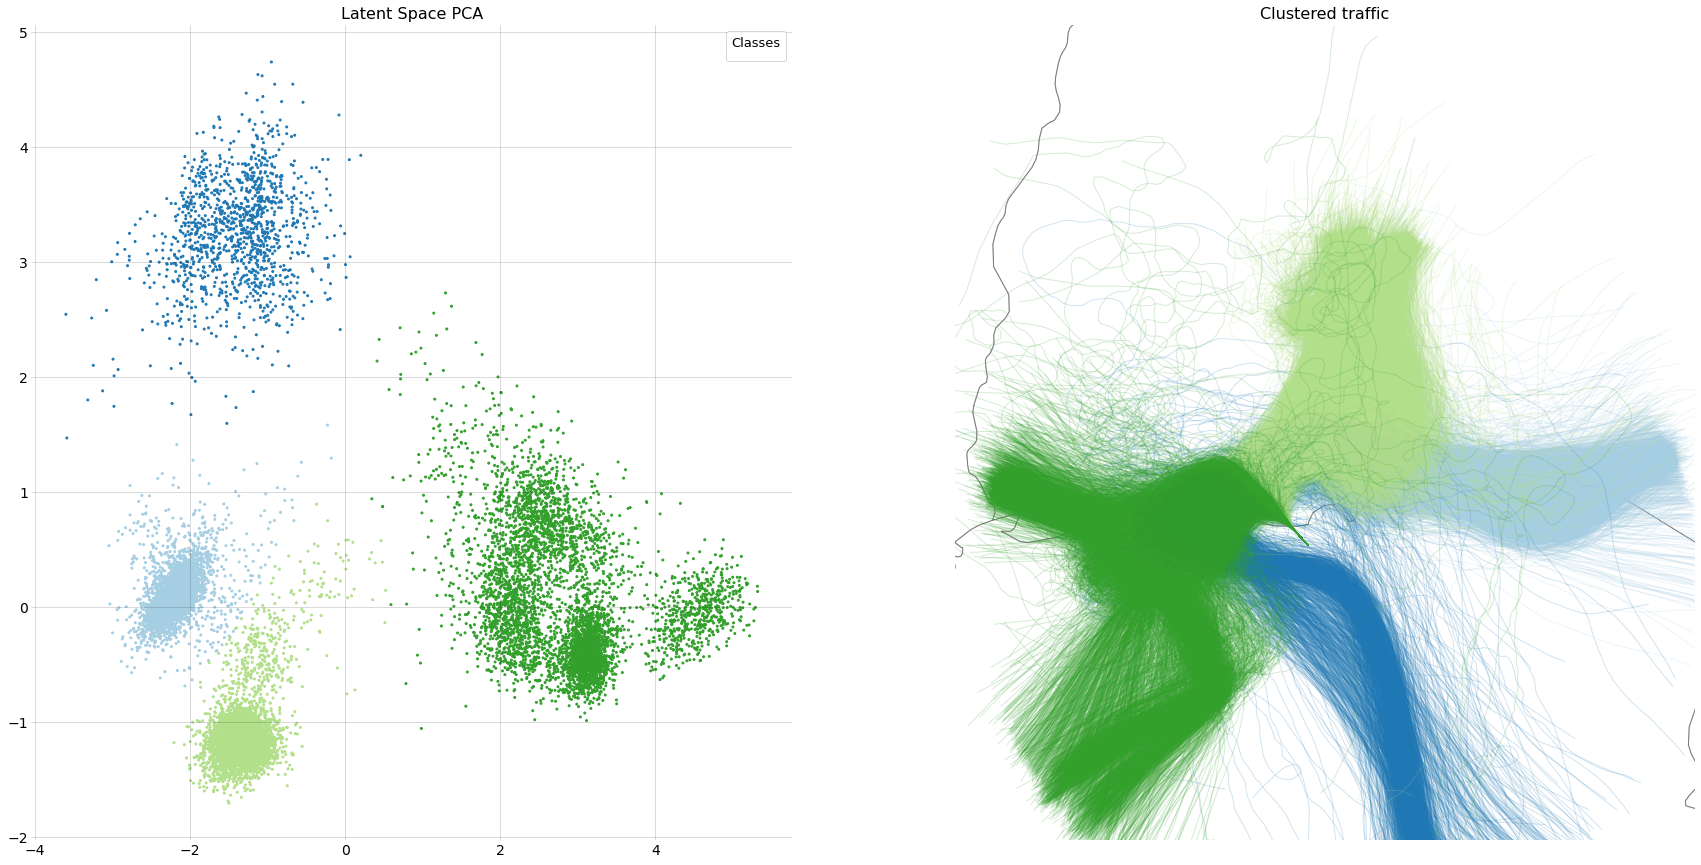

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from traffic.core.projection import EuroPP
from traffic.drawing import countries

Z = t_FCAE.latent_space()

pca = PCA(n_components=2).fit(Z)
Z_embedded = pca.transform(Z)
print("Explained variance ratio : ", pca.explained_variance_ratio_)

#Clustering on the pca transformation 
cluster = SpectralClustering(n_clusters=4, gamma = 8.0).fit_predict(Z_embedded)
print("Clustering done")

labels = cluster

traffics = []
for i in np.unique(labels):
    print("traffic : ", i)
    decoded = t_FCAE.decode(torch.Tensor(Z[labels== i]))
    traffics.append(g_FCAE.build_traffic(decoded, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False))


color_cycle = "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c #fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
colors = [color_cycle[i] for i in labels]

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 15))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122, projection=EuroPP())
    

    scat1 = ax0.scatter(Z_embedded[:, 0], Z_embedded[:, 1], s=4, c = colors)
    ax0.title.set_text("Latent Space PCA")
    legend1 = ax0.legend(*scat1.legend_elements(),
                    loc="upper right", title="Classes")

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Clustered traffic")
    for i, traf in enumerate(traffics) :
        traf.plot(ax1, alpha=0.2, color = color_cycle[i])

    plt.show()

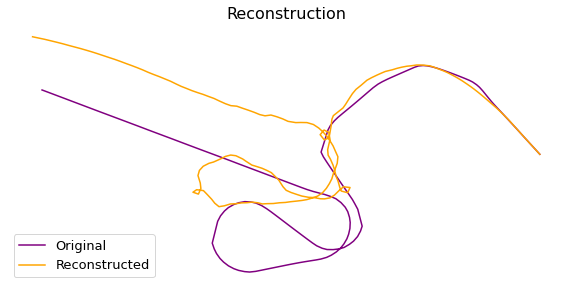

In [17]:
from traffic.core.projection import EuroPP
from traffic.drawing import countries
import matplotlib.pyplot as plt

#Comparison of a trajectory and it's reconstructed counterpart

# j = np.random.randint(len(dataset.data))
j = 10795

original = dataset_FCAE.data[j].unsqueeze(0)
if len(original.shape) >= 3:
    original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset_FCAE.scaler.inverse_transform(original)
original_traf = g_FCAE.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

reconstructed = t_FCAE.decode(t_FCAE.AE.encoder(dataset_FCAE.data[j].unsqueeze(0)))
reconstructed_traf = g_FCAE.build_traffic(reconstructed, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    ax.set_title("Reconstruction")
    original_traf.plot(ax, c="purple", label="Original")
    reconstructed_traf.plot(ax, c="orange", label = "Reconstructed")
    plt.legend()

    plt.show()

## TCAE

In [12]:
dataset_TCAE = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [13]:
path = "../../deep_traffic_generation/lightning_logs/tcae/version_9/"

t_TCAE = AutoEncoder(X = dataset_TCAE, AE_type="TCAE")
t_TCAE.load(path, dataset_TCAE.parameters)
g_TCAE = Generation(generation=t_TCAE, features = t_TCAE.AE.hparams.features, scaler=dataset_TCAE.scaler) 

Explained variance ratio :  [0.29195145 0.12578496]
Clustering done
traffic :  0
traffic :  1
traffic :  2
traffic :  3


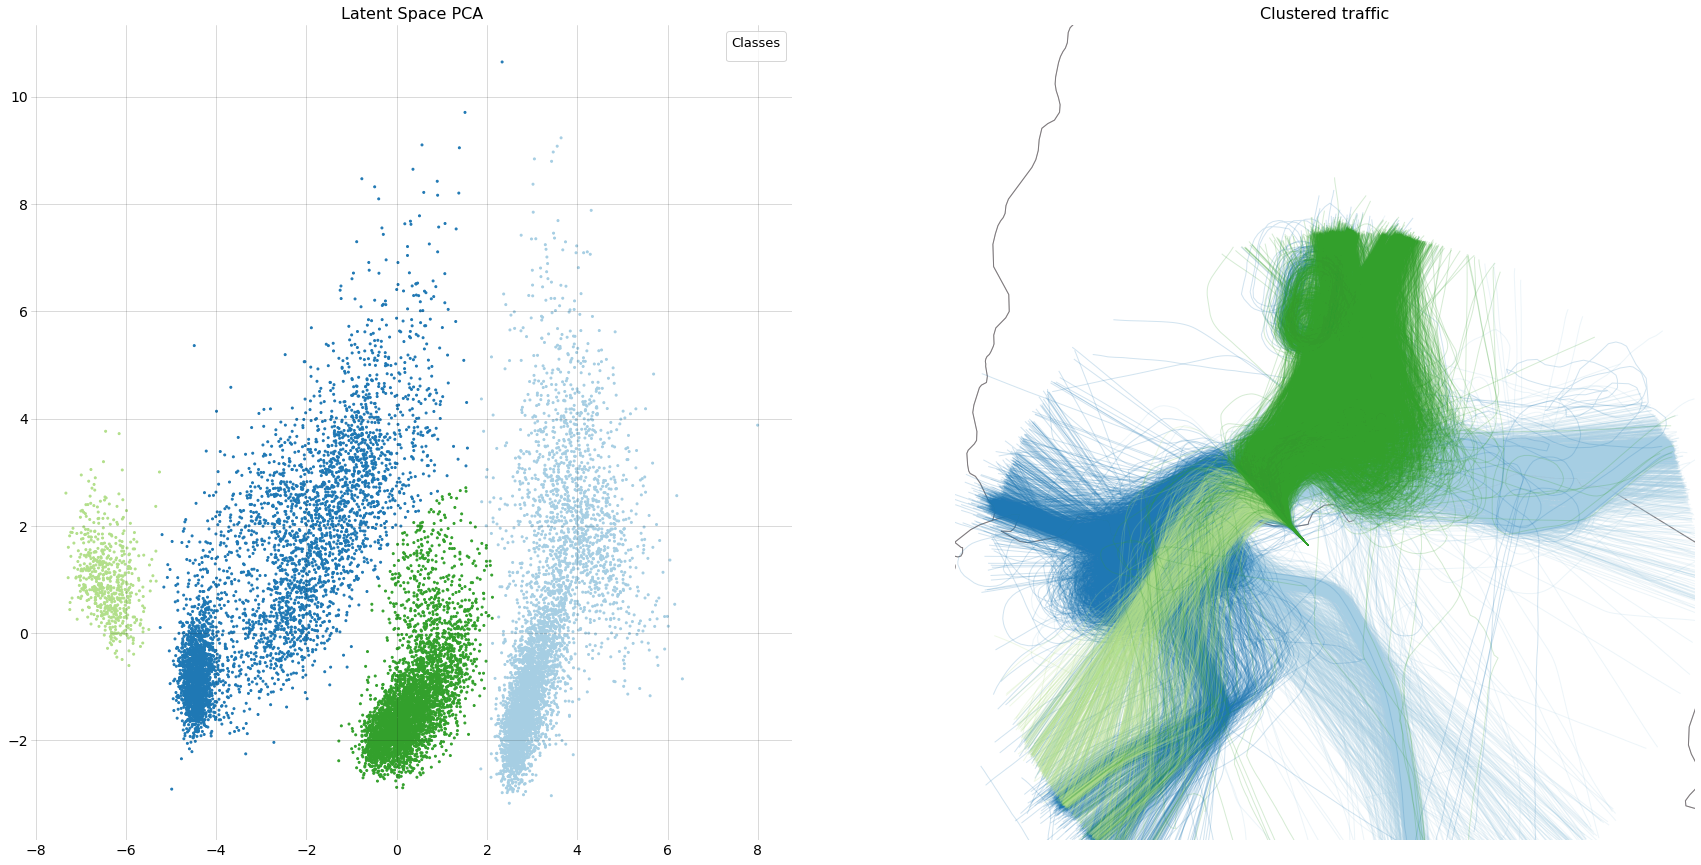

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from traffic.core.projection import EuroPP
from traffic.drawing import countries

Z = t_TCAE.latent_space()

pca = PCA(n_components=2).fit(Z)
Z_embedded = pca.transform(Z)
print("Explained variance ratio : ", pca.explained_variance_ratio_)

#Clustering on the pca transformation
cluster = SpectralClustering(n_clusters=4, gamma = 8.0).fit_predict(Z_embedded)
print("Clustering done")

labels = cluster

traffics = []
for i in np.unique(labels):
    print("traffic : ", i)
    decoded = t_TCAE.decode(torch.Tensor(Z[labels== i]))
    traffics.append(g_TCAE.build_traffic(decoded, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False))


color_cycle = "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c #fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
colors = [color_cycle[i] for i in labels]

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 15))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122, projection=EuroPP())
    

    scat1 = ax0.scatter(Z_embedded[:, 0], Z_embedded[:, 1], s=4, c = colors)
    ax0.title.set_text("Latent Space PCA")
    legend1 = ax0.legend(*scat1.legend_elements(),
                    loc="upper right", title="Classes")

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Clustered traffic")
    for i, traf in enumerate(traffics) :
        traf.plot(ax1, alpha=0.2, color = color_cycle[i])

    plt.show()

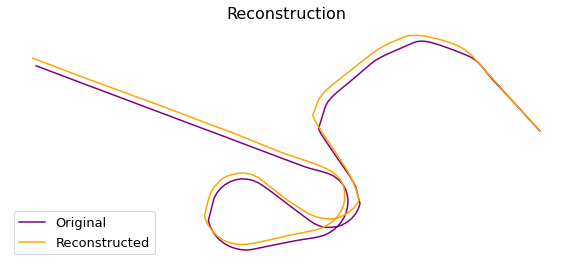

In [16]:
from traffic.core.projection import EuroPP
from traffic.drawing import countries
import matplotlib.pyplot as plt

#Comparison of a trajectory and it's reconstructed counterpart

# j = np.random.randint(len(dataset.data))
j = 10795

original = dataset_TCAE.data[j].unsqueeze(0)
if len(original.shape) >= 3:
    original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset_TCAE.scaler.inverse_transform(original)
original_traf = g_TCAE.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

reconstructed = t_TCAE.decode(t_TCAE.AE.encoder(dataset_TCAE.data[j].unsqueeze(0)))
reconstructed_traf = g_TCAE.build_traffic(reconstructed, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    ax.set_title("Reconstruction")
    original_traf.plot(ax, c="purple", label="Original")
    reconstructed_traf.plot(ax, c="orange", label = "Reconstructed")
    plt.legend()

    plt.show()

# Variational Autoencoder

In [18]:
dataset_TCVAE = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [19]:
path = "../../deep_traffic_generation/lightning_logs/tcvae/version_1/"

t_TCVAE = SingleStageVAE(X = dataset_TCVAE, sim_type = "generation")
t_TCVAE.load(path, dataset_TCVAE.parameters)
g_TCVAE = Generation(generation=t_TCVAE, features = t_TCVAE.VAE.hparams.features, scaler=dataset_TCVAE.scaler) 

Explained variance ratio :  [0.29797778 0.15525647]
Clustering done
traffic :  0
traffic :  1
traffic :  2
traffic :  3
traffic :  4
traffic :  5
traffic :  6


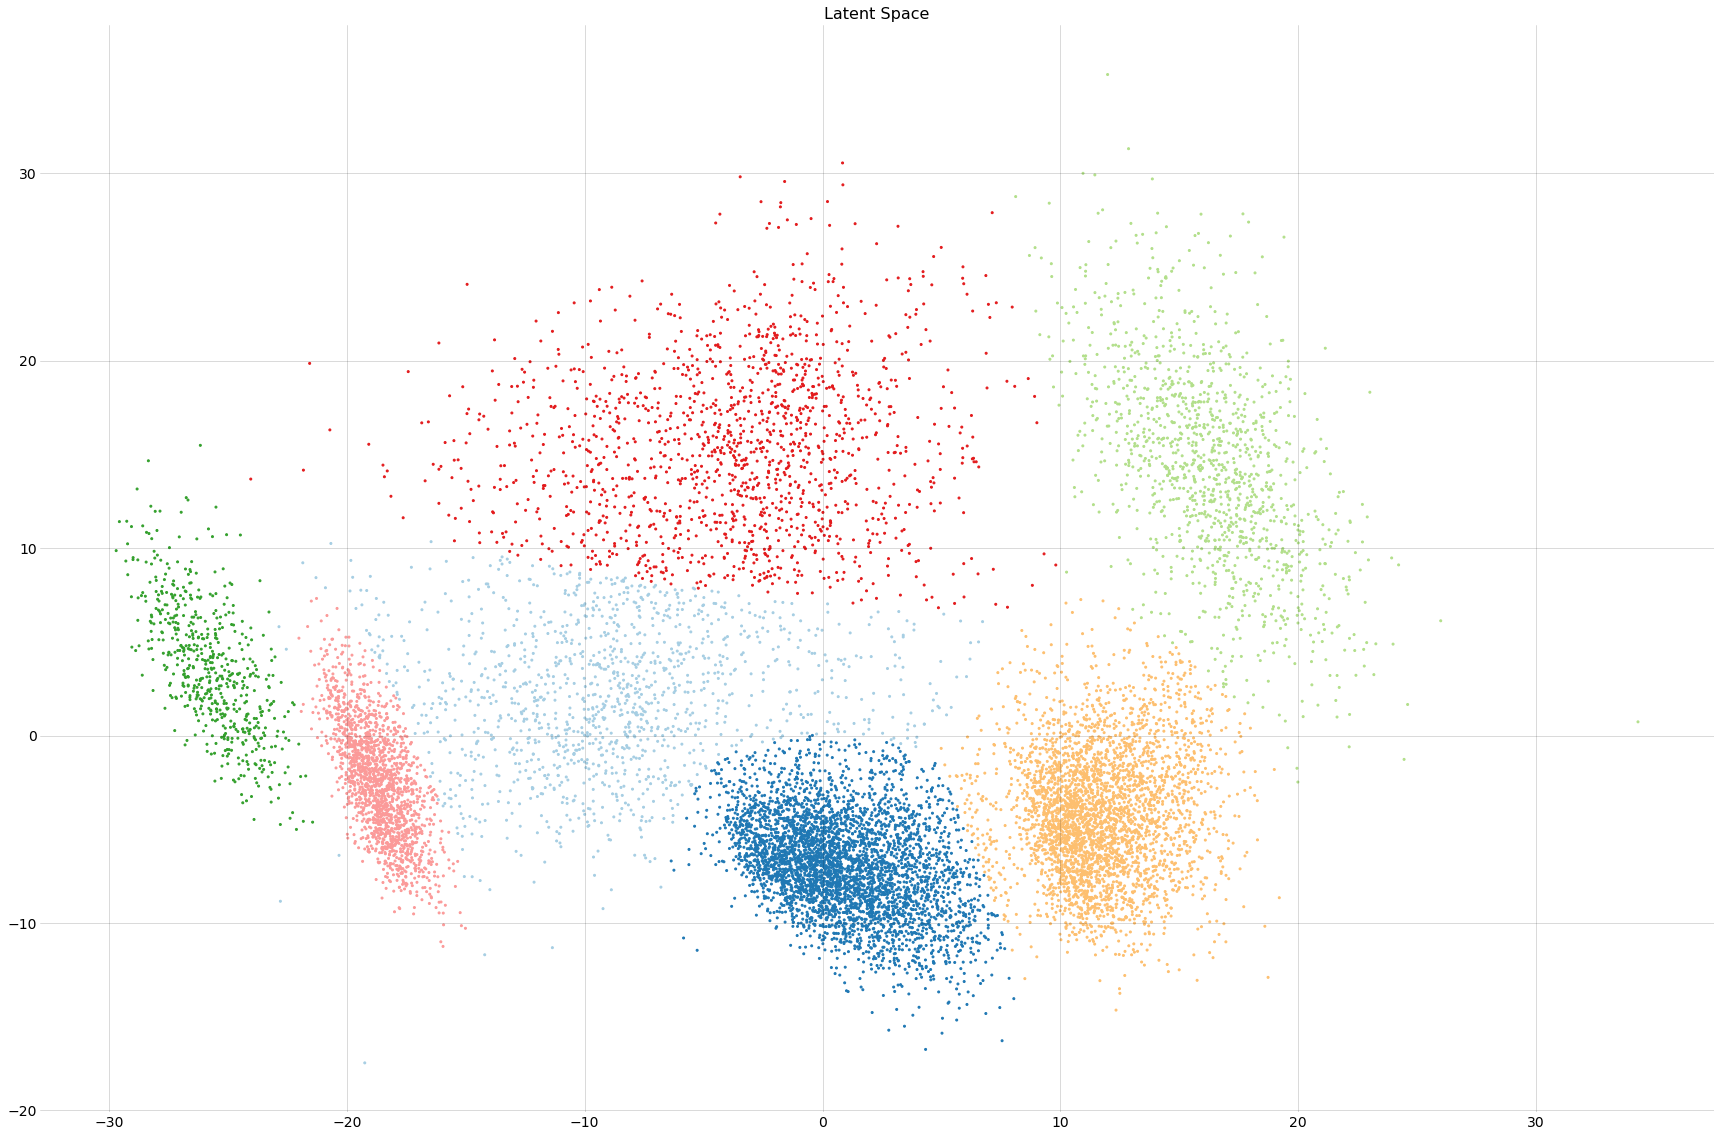

In [20]:
from sklearn.mixture import GaussianMixture
from traffic.core.projection import EuroPP
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from traffic.drawing import countries

n_gen = 1
Z = t_TCVAE.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded = pca.transform(Z)
print("Explained variance ratio : ", pca.explained_variance_ratio_)

labels = GaussianMixture(n_components=7).fit_predict(Z_embedded)
print("Clustering done")

traffics = []
for i in np.unique(labels):
    print("traffic : ", i)
    decoded = t_TCVAE.decode(torch.Tensor(Z[labels == i]))
    traffics.append(g_TCVAE.build_traffic(decoded, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False))


color_cycle = "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c #fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
colors = [color_cycle[i] for i in labels]

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111)

    scat2 = ax.scatter(Z_embedded[:, 0], Z_embedded[:, 1], s=4, c = colors)
    ax.title.set_text("Latent Space")

    plt.show()

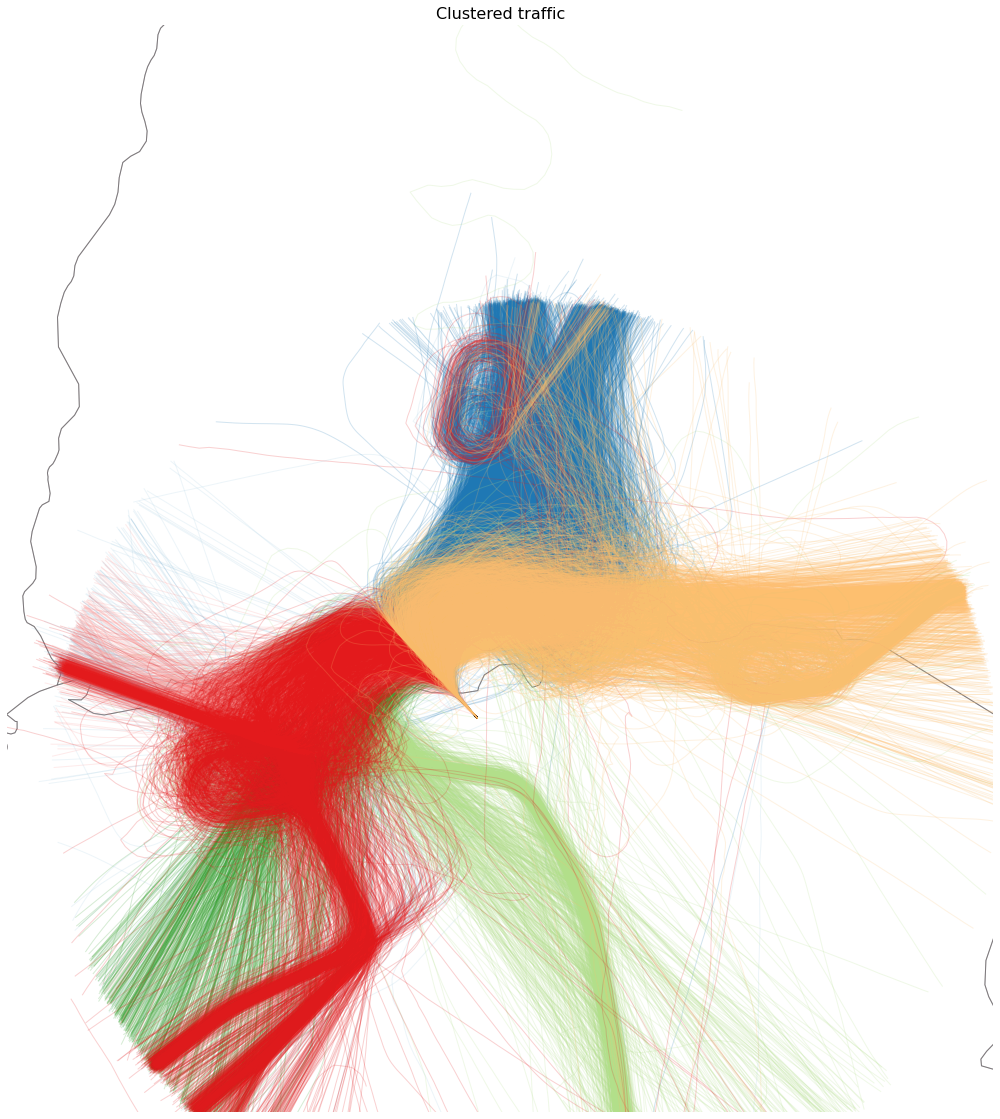

In [21]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111, projection=EuroPP())

    ax.add_feature(countries())
    ax.figure
    ax.set_extent((7.5, 9.5, 47, 48.5))
    ax.title.set_text("Clustered traffic")
    for i, traffic in enumerate(traffics) :
        traffic.plot(ax, alpha=0.2, color = color_cycle[i])

    plt.show()

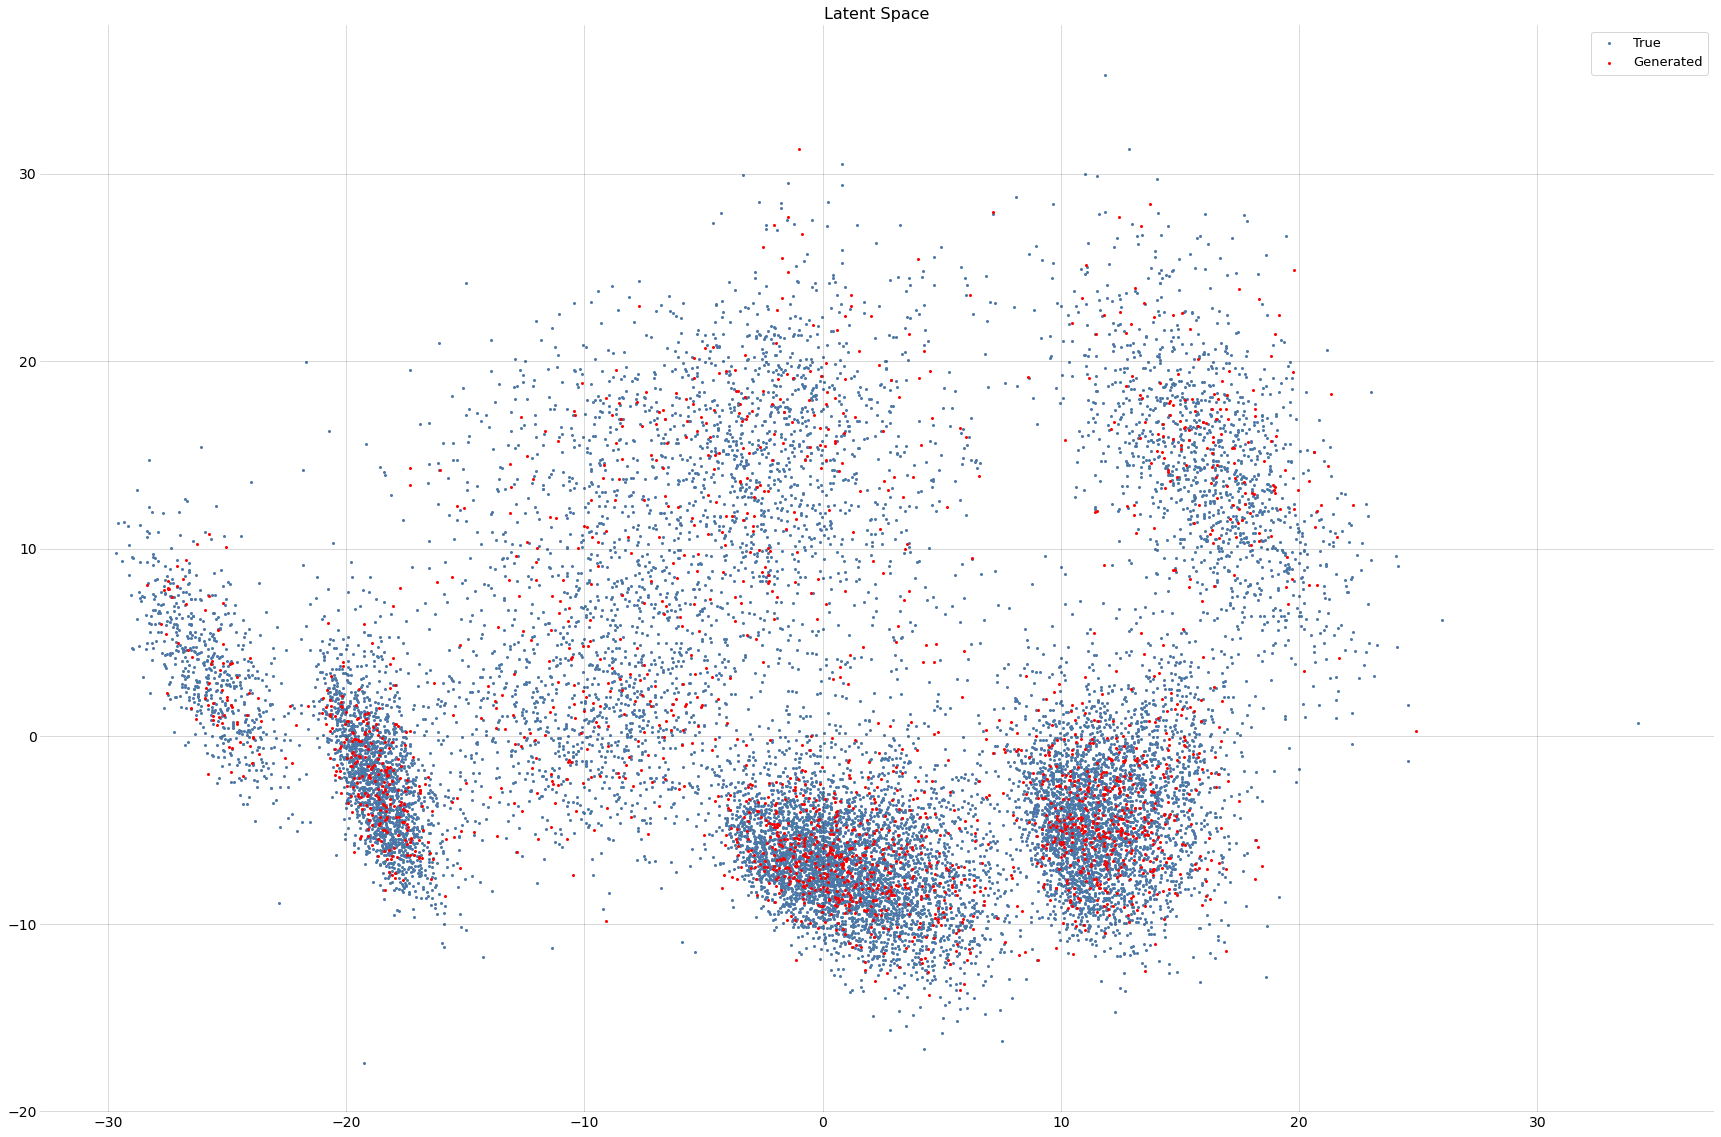

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_gen = 2000
Z = t_TCVAE.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded = pca.transform(Z)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(30, 20))

    ax.scatter(Z_embedded[:-n_gen, 0], Z_embedded[:-n_gen, 1], s=4, label = "True")
    ax.scatter(Z_embedded[-n_gen:, 0], Z_embedded[-n_gen:, 1], s=4, c='red', label = "Generated")
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()

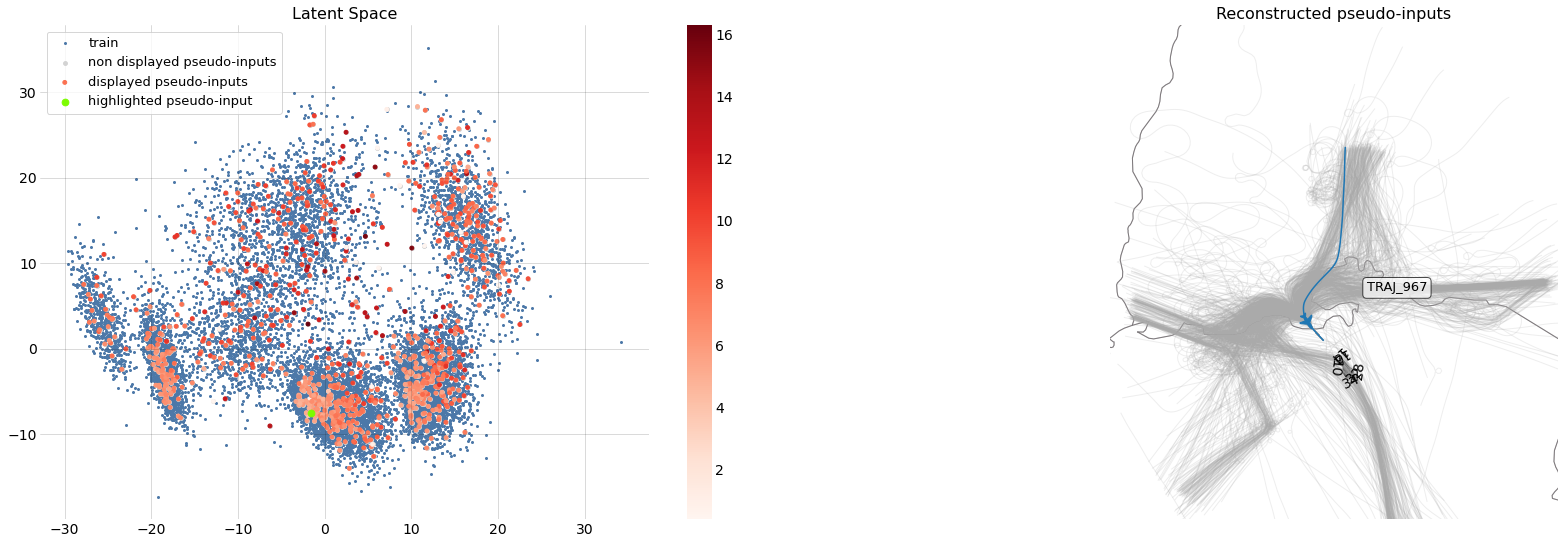

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
from scipy.signal import savgol_filter

#Computing the pseudo inputs

#Vampprior
pseudo_X = t_TCVAE.VAE.lsr.pseudo_inputs_NN(t_TCVAE.VAE.lsr.idle_input) 
pseudo_X = pseudo_X.view((pseudo_X.shape[0], 4, 200))
pseudo_h = t_TCVAE.VAE.encoder(pseudo_X)
pseudo_means = t_TCVAE.VAE.lsr.z_loc(pseudo_h)
pseudo_scales = (t_TCVAE.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

#Reconstructed pseudo-inputs
out = t_TCVAE.decode(pseudo_means)
#Neural net don't predict exaclty timedelta = 0 for the first observation
out[:,3] = 0
#The track prediction is filtered (smoothen trajectories)
out[:,0::4] = savgol_filter(out[:,0::4], 11, 3)
out_traf = g_TCVAE.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

#latent spaces from train dataset and pseudo_inputs
z_train = t_TCVAE.latent_space(1)

Z = np.concatenate((z_train, pseudo_means.detach().numpy()), axis=0)

pca = PCA(n_components=2).fit(Z[:-len(pseudo_means)])
Z_embedded = pca.transform(Z)

#col depending on the scales
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())

    fidx = list(map(lambda x: int(x.split("_")[1]),out_traf.flight_ids))
    k = np.random.choice(fidx)
    fidx = np.array(fidx) + len(z_train)

    ax0.scatter(Z_embedded[:-len(pseudo_means), 0], Z_embedded[:-len(pseudo_means), 1], s=4, label = "train")
    points0 = ax0.scatter(Z_embedded[-len(pseudo_means):, 0], Z_embedded[-len(pseudo_means):, 1], s=15, c="lightgrey", label = "non displayed pseudo-inputs")
    points1 = ax0.scatter(Z_embedded[fidx, 0], Z_embedded[fidx, 1], s=15, c=col[fidx - len(z_train)], cmap = "Reds",  label = "displayed pseudo-inputs")
    ax0.scatter(Z_embedded[(len(z_train)+k), 0], Z_embedded[(len(z_train)+k), 1], s=45, c='lawngreen', label = "highlighted pseudo-input")
    ax0.title.set_text("Latent Space")
    ax0.legend()
    fig.colorbar(points1, ax=ax0)

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Reconstructed pseudo-inputs")
    out_traf.plot(ax1, alpha=0.2)
    out_traf["TRAJ_"+str(k)].plot(ax1, color="#1f77b4", lw=1.5)
    out_traf["TRAJ_"+str(k)].at_ratio(0.85).plot(
        ax1,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax1, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax1,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

[783 326]
red scale : tensor(6.9769, grad_fn=<SelectBackward>)
green scale : tensor(8.5092, grad_fn=<SelectBackward>)


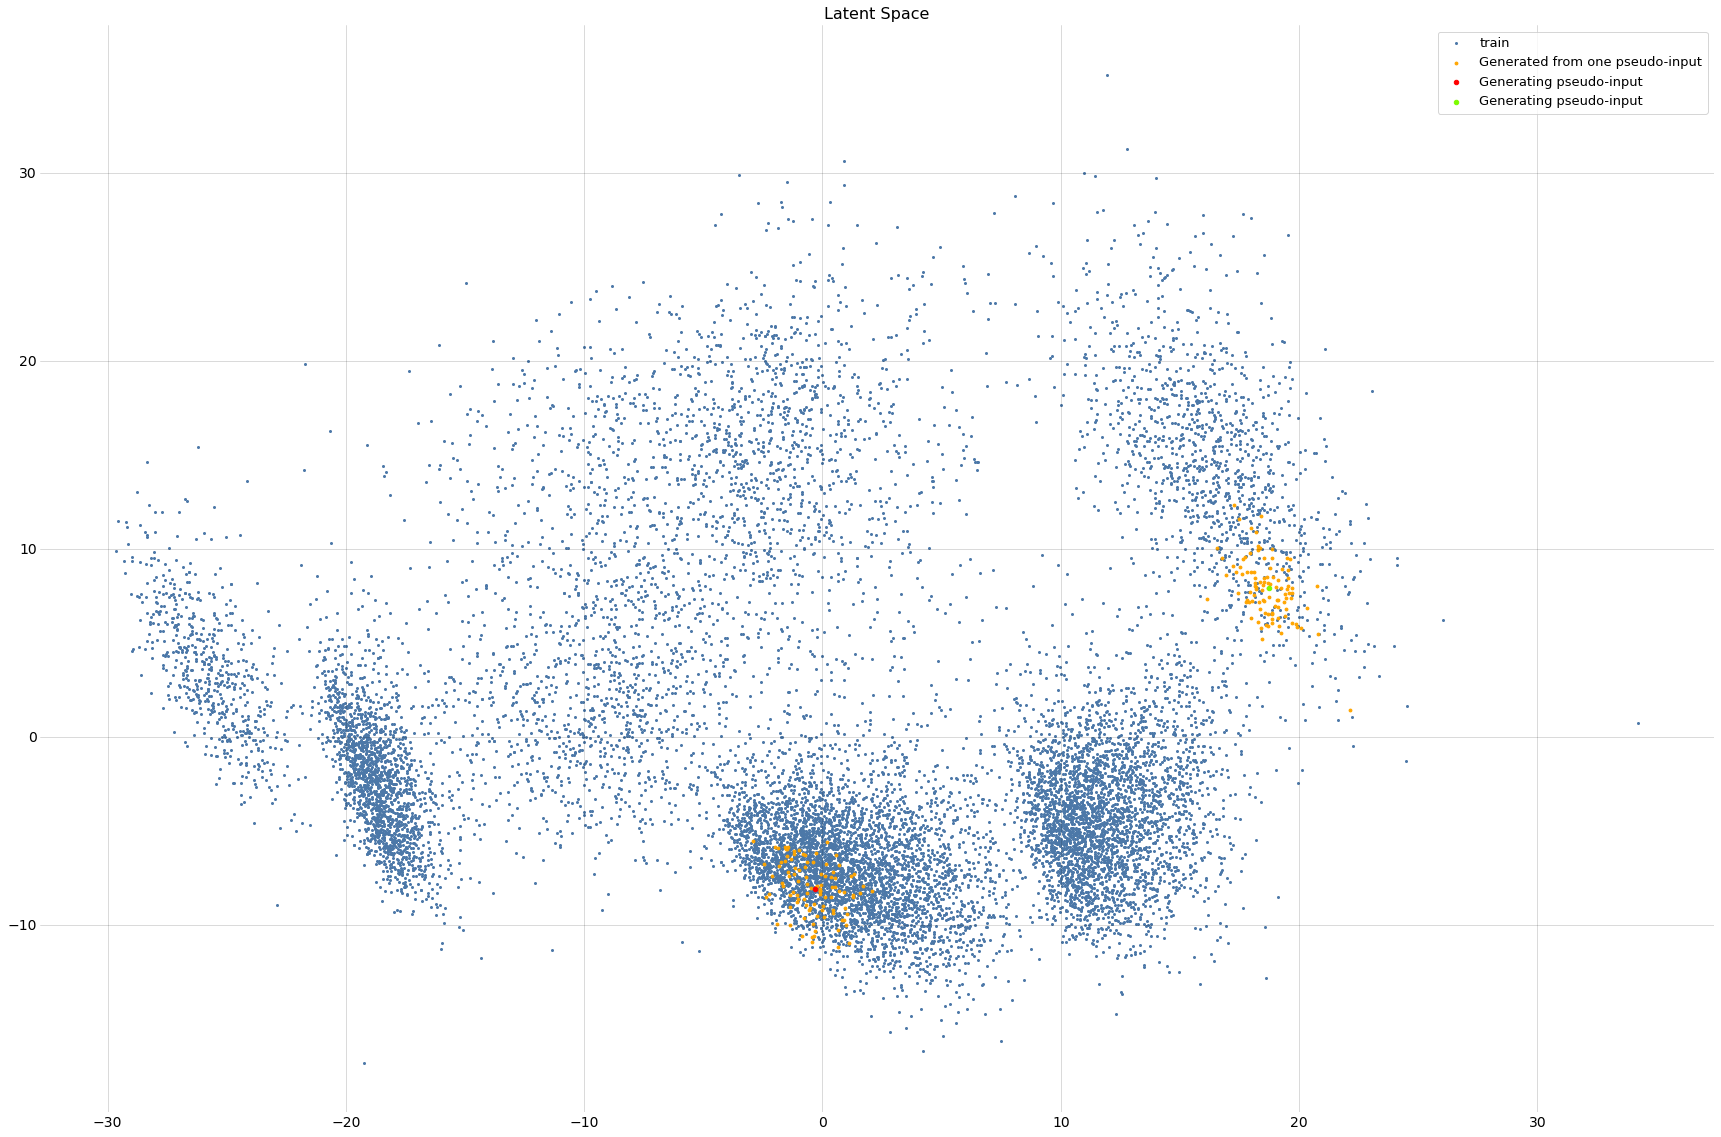

In [25]:
i = np.random.randint(int(len(pseudo_means)/2))

col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()
js = np.argsort(col)[[i,-i]]
# js = [759,323]

n_gen = 100

dist1 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[0]], pseudo_scales[js[0]]), 1)
gen1 = dist1.sample(torch.Size([n_gen]))

dist2 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[1]], pseudo_scales[js[1]]), 1)
gen2 = dist2.sample(torch.Size([n_gen]))

gen = torch.cat((gen1, gen2, pseudo_means[js]), axis=0)
out = t_TCVAE.decode(gen)
out_traf = g_TCVAE.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

concat = np.concatenate((z_train, gen.detach().numpy()))
pca = PCA(n_components=2).fit(concat[:-len(gen)])
gen_embedded = pca.transform(concat)

print(js)
col = torch.norm(pseudo_scales[js], dim = 1, p = 2)
print("red scale :", col[0])
print("green scale :", col[1])

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111)

    ax.scatter(gen_embedded[:-len(gen), 0], gen_embedded[:-len(gen), 1], s=4, label = "train")
    ax.scatter(gen_embedded[-len(gen):, 0], gen_embedded[-len(gen):, 1], s=8, c='orange', label = "Generated from one pseudo-input")
    ax.scatter(gen_embedded[-2, 0], gen_embedded[-2, 1], s=20, c='red', label = "Generating pseudo-input")
    ax.scatter(gen_embedded[-1, 0], gen_embedded[-1, 1], s=20, c="lawngreen", label = "Generating pseudo-input")
    ax.title.set_text("Latent Space")
    ax.legend()

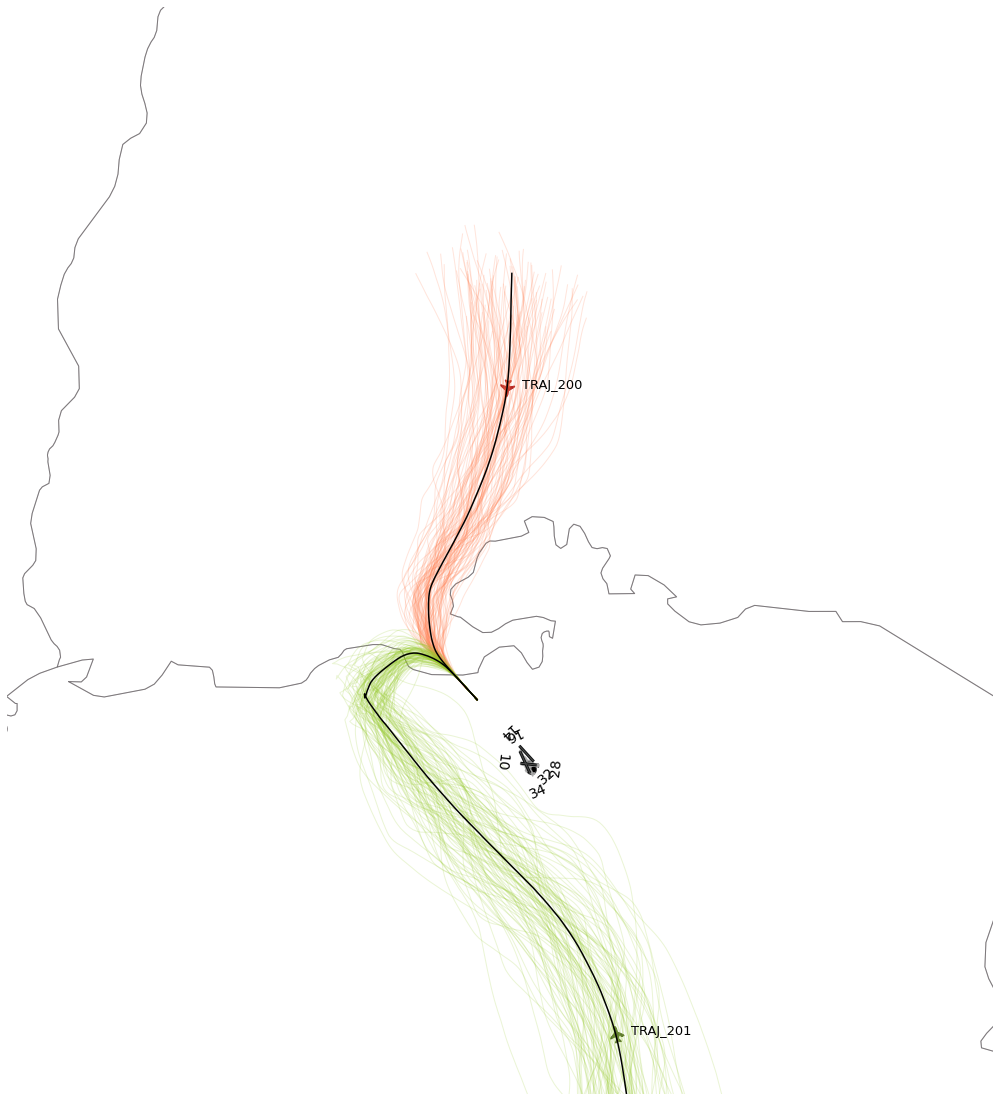

In [26]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111, projection=EuroPP())

    ax.add_feature(countries())
    ax.figure
    ax.set_extent((7.5, 9.5, 47, 48.5))
    out_traf[["TRAJ_" + str(i) for i in range(n_gen)]].plot(ax, color="coral", alpha=0.2)
    out_traf[["TRAJ_" + str(i) for i in range(n_gen, n_gen*2)]].plot(ax, color="yellowgreen", alpha=0.2)

    out_traf["TRAJ_"+str(len(out_traf)-2)].plot(ax, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-2)].at_ratio(0.2).plot(
        ax,
        color="firebrick",
    )

    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-1)].at_ratio(0.2).plot(
        ax,
        color="darkolivegreen",
    )

    airports["LSZH"].plot(ax, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )